In [22]:
import pandas as pd
import glob
import shutil
import torch
import torch.nn as nn
from torch.optim import lr_scheduler

from utils import data_transforms, mask_transforms, UNETR_2D

In [23]:

from torch.utils.data import Dataset
from PIL import Image
import glob
import matplotlib.pyplot as plt

class VesselDataset(Dataset):
    def __init__(self, 
                data_dir = '/mnt/c/Users/PCM/Dropbox/ee638/Vessel/', 
                phase='train', 
                mode='multiclass_contrastive', 
                datalen = 100,
                seed = 100):
        self.folder_path = data_dir
        self.phase = phase
        self.img_files = glob.glob(self.folder_path + self.phase + '/images/*')
        self.mask_imgs = glob.glob(self.folder_path + self.phase + '/mask/*')
        self.data_transforms = data_transforms[phase]
        self.mask_transforms = mask_transforms
        self.datalen = len(self.img_files)
        
    def __getitem__(self, index):
        img = self.img_files[index]
        mask = self.mask_imgs[index]

        img = self.data_transforms(Image.open(img))
        mask = self.mask_transforms(Image.open(mask))

        mask = (mask[0] > 0) & (mask[0] < 1) * 1

        return img, mask
    
    def __len__(self):
        return self.datalen


In [24]:
image_datasets = {x: VesselDataset(phase=x) for x in ['train', 'val', 'test']}
batch_size = {'train':10, 'val':10, 'test':1}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size[x], shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val',  'test']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# im, mask = image_datasets['train'][3]

cuda:0


In [5]:
config = {}
config["image_size"] = 224
config["num_layers"] = 12
config["hidden_dim"] = 768
config["mlp_dim"] = 3072
config["num_heads"] = 12
config["dropout_rate"] = 0.1
config["num_patches"] = 196
config["patch_size"] = 16
config["width_patches"] = 14
config["num_channels"] = 3
LOSS_NAME = "dice" #ce/bce/dice/dicefocal
DATA_SPLIT = "split1" #split1/split2/central

unetr = UNETR_2D(config, pretrained=f'/mnt/c/Users/PCM/Documents/GitHub/SSL-FL/pretrained/SSFL/{DATA_SPLIT}/checkpoint-6.pth',device=device)
# unetr = UNETR_2D(config, pretrained=None, device=device)
# output = unetr(x)
# print(output.shape)

from monai.losses import DiceLoss, DiceFocalLoss
import torch.optim as optim
momentum = 0.9
lr = 0.01

# Define loss
if LOSS_NAME == "ce":
    criterion = nn.CrossEntropyLoss()
elif LOSS_NAME=='dicefocal':
    criterion= DiceFocalLoss(reduction='mean', sigmoid = True)
elif LOSS_NAME=='dice':
    criterion= DiceLoss(reduction='mean', sigmoid = True)

# criterion.= DiceLoss(reduction='mean', sigmoid = True)
optimizer_ft = optim.SGD([{'params': unetr.parameters()}], lr=lr, momentum=momentum)
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.5)

for param in unetr.encoder.parameters():
    param.requires_grad = False
for param in unetr.trans_encoder_layers.parameters():
    param.requires_grad = False
for param in unetr.patch_embed.parameters():
    param.requires_grad = False

In [60]:
from datetime import date
trainlosslist = []
vallosslist = []
unetr = unetr.to(device)
curr_loss = 100
for e in range(30):
    training_acc = 0
    val_acc = 0
    training_loss_test = 0.0
    val_loss_test = 0.0
    for inputs, masks in dataloaders['train']:
        unetr.train()
        im = inputs.to(device)
        masks = masks.to(device)
        # zero the parameter gradients
        optimizer_ft.zero_grad()
        outputs = unetr(im)
        # print(outputs.shape)
        loss = criterion(outputs.squeeze(1), masks)

        loss.backward()
        optimizer_ft.step()
        training_loss_test += loss.item()
        trainlosslist.append(training_loss_test)

    for inputs, masks in dataloaders['val']:
        unetr.eval()
        im = inputs.to(device)
        masks = masks.to(device)
        with torch.no_grad():
            outputs = unetr(im)
            # print(outputs.shape)
            dice = criterion(outputs, masks.unsqueeze(1))
            val_loss_test += dice.item()
            vallosslist.append(val_loss_test)

    if(val_loss_test <= curr_loss):
        curr_loss = val_loss_test
        print(f"New best mode at epoch {e}")
        today = date.today()
        torch.save(unetr.state_dict(), f'./pretrained/vessel/best-dice-unetr-{DATA_SPLIT}-{LOSS_NAME}-{str(today)}.pt')
    
    # scheduler.step()

    print(f"E{e} With LR {optimizer_ft.param_groups[0]['lr']}","avg val dice: ", val_loss_test / dataset_sizes['val']*batch_size['val'] , "avg traning loss: ", training_loss_test / dataset_sizes['train']*batch_size['train'])

New best mode at epoch 0
E0 With LR 0.01 avg val dice:  0.5886743366718292 avg traning loss:  0.615624795525761
New best mode at epoch 1
E1 With LR 0.01 avg val dice:  0.5822225213050842 avg traning loss:  0.5802152621544013
New best mode at epoch 2
E2 With LR 0.01 avg val dice:  0.5686167180538177 avg traning loss:  0.5533090082265563
New best mode at epoch 3
E3 With LR 0.01 avg val dice:  0.5455862581729889 avg traning loss:  0.5381265030068867
New best mode at epoch 4
E4 With LR 0.01 avg val dice:  0.5173044204711914 avg traning loss:  0.5265032335863274
New best mode at epoch 5
E5 With LR 0.01 avg val dice:  0.5061648041009903 avg traning loss:  0.5189308625156597
New best mode at epoch 6
E6 With LR 0.01 avg val dice:  0.4935302585363388 avg traning loss:  0.5135621913408829
New best mode at epoch 7
E7 With LR 0.01 avg val dice:  0.4793110191822052 avg traning loss:  0.5082295254125434
New best mode at epoch 8
E8 With LR 0.01 avg val dice:  0.47636766731739044 avg traning loss:  0.

## Test

In [15]:
testsegm = UNETR_2D(config, device=device)
state_dict = torch.load('/mnt/c/Users/PCM/Documents/GitHub/SSL-FL/pretrained/vessel/best-dice-unetr-scratch-dice-2024-04-30.pt')
testsegm.load_state_dict(state_dict, strict=False)
testsegm.to(device)

UNETR_2D(
  (encoder): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1)

In [8]:
test_dice = 0.0
test_jacard = 0.0

for inputs, masks in dataloaders['test']:
    testsegm.eval()
    im = inputs.to(device)
    masks = masks.to(device)
    with torch.no_grad():
        outputs = testsegm(im)
        # print(outputs.shape)
        dice = criterion(outputs, masks.unsqueeze(1))
        test_dice += dice.item()

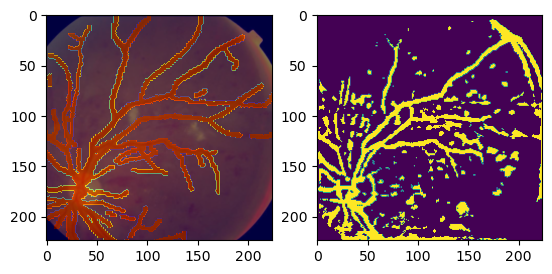

In [21]:
import numpy as np
def imshow3(inp, mask, alpha=0.5, plt = plt, title=None, mean=np.array([0.6821, 0.4575, 0.2626]), std=np.array([0.1324, 0.1306, 0.1022])):
    """Input shound be tensor [3,224,224]"""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = mean
    # std = std
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.imshow(mask, cmap='jet', alpha=alpha)
    if title is not None:
        plt.title(title)

sample_test, label_test = image_datasets['test'][2]
fig, axs = plt.subplots(1, 2)
imshow3(sample_test, label_test, alpha = 0.5, plt=axs[0])
axs[1].imshow(testsegm(sample_test.unsqueeze(0).to(device))[0][0].cpu().detach().numpy() > 4)

In [70]:
test_dice/20

0.45401765704154967

# AUTO RUN

In [25]:
config = {}
config["image_size"] = 224
config["num_layers"] = 12
config["hidden_dim"] = 768
config["mlp_dim"] = 3072
config["num_heads"] = 12
config["dropout_rate"] = 0.1
config["num_patches"] = 196
config["patch_size"] = 16
config["width_patches"] = 14
config["num_channels"] = 3

In [27]:
def run(config, no_of_exp=10, LOSS_NAME='dice', DATA_SPLIT='split1', req_grad = False, pretrained = True):
    all_test_dice = []
    for ii in range(no_of_exp):
        #Load dataset
        image_datasets = {x: VesselDataset(phase=x) for x in ['train', 'val', 'test']}
        batch_size = {'train':10, 'val':10, 'test':1}
        dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size[x], shuffle=True, num_workers=4)
                    for x in ['train', 'val', 'test']}
        # dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val',  'test']}

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        # Define utils
        LOSS_NAME = LOSS_NAME #ce/bce/dice/dicefocal
        DATA_SPLIT = DATA_SPLIT #split1/split2/central
        if(pretrained):
            unetr = UNETR_2D(config, pretrained=f'/mnt/c/Users/PCM/Documents/GitHub/SSL-FL/pretrained/SSFL/{DATA_SPLIT}/checkpoint-6.pth',device=device)
        else:
            unetr = UNETR_2D(config, pretrained= None, device=device)
        from monai.losses import DiceLoss, DiceFocalLoss
        import torch.optim as optim
        momentum = 0.9
        lr = 0.01
        
        # Define loss
        if LOSS_NAME == "ce":
            criterion = nn.CrossEntropyLoss()
        elif LOSS_NAME=='dicefocal':
            criterion= DiceFocalLoss(reduction='mean', sigmoid = True)
        elif LOSS_NAME=='dice':
            criterion= DiceLoss(reduction='mean', sigmoid = True)

        # criterion.= DiceLoss(reduction='mean', sigmoid = True)
        optimizer_ft = optim.SGD([{'params': unetr.parameters()}], lr=lr, momentum=momentum)
        # scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.5)

        for param in unetr.encoder.parameters():
            param.requires_grad = req_grad
        for param in unetr.trans_encoder_layers.parameters():
            param.requires_grad = req_grad
        for param in unetr.patch_embed.parameters():
            param.requires_grad = req_grad

        trainlosslist = []
        vallosslist = []
        unetr = unetr.to(device)
        curr_loss = 100
        for e in range(30):
            training_acc = 0
            val_acc = 0
            training_loss_test = 0.0
            val_loss_test = 0.0
            for inputs, masks in dataloaders['train']:
                unetr.train()
                im = inputs.to(device)
                masks = masks.to(device)
                # zero the parameter gradients
                optimizer_ft.zero_grad()
                outputs = unetr(im)
                # print(outputs.shape)
                loss = criterion(outputs.squeeze(1), masks)

                loss.backward()
                optimizer_ft.step()
                training_loss_test += loss.item()
                trainlosslist.append(training_loss_test)

            for inputs, masks in dataloaders['val']:
                unetr.eval()
                im = inputs.to(device)
                masks = masks.to(device)
                with torch.no_grad():
                    outputs = unetr(im)
                    # print(outputs.shape)
                    dice = criterion(outputs, masks.unsqueeze(1))
                    val_loss_test += dice.item()
                    vallosslist.append(val_loss_test)

            if(val_loss_test <= curr_loss):
                curr_loss = val_loss_test
                testsegm = unetr
                # print(f"New best mode at epoch {e}")
                # today = date.today()
                # torch.save(unetr.state_dict(), f'./pretrained/vessel/best-dice-unetr-{DATA_SPLIT}-{LOSS_NAME}-{str(today)}.pt')
    ## TESTING TIME
        test_dice = 0.0

        for inputs, masks in dataloaders['test']:
            testsegm.eval()
            im = inputs.to(device)
            masks = masks.to(device)
            with torch.no_grad():
                outputs = testsegm(im)
                # print(outputs.shape)
                dice = criterion(outputs, masks.unsqueeze(1))
                test_dice += dice.item()
        all_test_dice.append(test_dice/20) 
            # scheduler.step()
            # print(f"E{e} With LR {optimizer_ft.param_groups[0]['lr']}","avg val dice: ", val_loss_test / dataset_sizes['val']*batch_size['val'] , "avg traning loss: ", training_loss_test / dataset_sizes['train']*batch_size['train'])
        print('#RUN', ii)
    return all_test_dice


In [28]:
all_test_dice = run(config, no_of_exp=10, LOSS_NAME='dice', DATA_SPLIT='central', req_grad=True, pretrained=False)

#RUN 0
#RUN 1
#RUN 2
#RUN 3
#RUN 4
#RUN 5
#RUN 6
#RUN 7
#RUN 8
#RUN 9


In [29]:
all_test_dice

[0.4242073029279709,
 0.4258830487728119,
 0.44446214735507966,
 0.429093798995018,
 0.4462155431509018,
 0.4496671974658966,
 0.44229571223258973,
 0.441649129986763,
 0.42045246362686156,
 0.42546207904815675]

In [58]:
dice_split1 = [0.4257246822118759, 0.44487003684043885, 0.48822055757045746, 0.4685061901807785, 0.44571414589881897, 0.4430254429578781, 0.4430293500423431, 0.4784053981304169,
 0.4435038059949875, 0.4440265417098999]
dice_central = [0.48214333951473237, 0.4238661229610443, 0.44631545841693876, 0.44633960723876953, 0.43115130364894866, 0.44064230620861056, 0.4480989515781403, 0.43008483946323395,
 0.42324002385139464, 0.45711531341075895]
dice_split2 = [0.43309529423713683, 0.4308618903160095, 0.44050526022911074, 0.4524711608886719, 0.44633340537548066, 0.44878864884376524, 0.444601508975029, 0.45699339509010317,
 0.4487419754266739, 0.47142466008663175]
dice_scratch = [0.42613716423511505, 0.4327721118927002, 0.4414540588855743, 0.45260023772716523, 0.44971420168876647, 0.43091723024845124, 0.4476142168045044, 0.44748036861419677,
 0.4406822681427002, 0.42538508772850037]
dicefocal_scratch = [0.6158446177840233, 0.6510266900062561, 0.6707885831594467, 0.6020459949970245, 0.6067952364683151, 0.6610658407211304, 0.6812659293413162, 0.6757644012570381,
 0.660801462829113, 0.5875850960612297]
dicefocal_central = [0.6255476146936416, 0.6086422026157379, 0.6229015722870826, 0.5976738095283508, 0.7059863969683647, 0.7762922585010529, 0.7237977981567383, 0.5803926572203636,
 0.7871459811925888, 0.6163648873567581]
dicefocal_split1 = [0.6230366215109825, 0.6012885615229606, 0.6006075397133828, 0.6277501538395882, 0.6338068142533302, 0.630143991112709, 0.6063518449664116, 0.5897041097283363,
 0.6221098497509956, 0.6053146675229073]
dicefocal_split2 = [0.6152740776538849, 0.645599976181984, 0.5919623255729676, 0.6158969178795815, 0.5869291469454765, 0.6077703326940537, 0.6194350153207779, 0.6061187490820885,
 0.5974309265613555, 0.5901368170976639]

In [30]:
import numpy as np
print('mean: ', np.mean(all_test_dice), 'std: ', np.std(all_test_dice))

mean:  0.43493884235620495 std:  0.010319570421875267


In [21]:
np.std(test_central)

0.016878390642000828

# Preprocessing

In [65]:
# phases = ['train', 'test', 'val']
# for phase in phases:
#     if(phase == 'train'):
#         folders = glob.glob('/mnt/c/Users/PCM/Dropbox/ee638/Vessel/AV/*')[:60]
#     elif(phase == 'val'):
#         folders = glob.glob('/mnt/c/Users/PCM/Dropbox/ee638/Vessel/AV/*')[60:80]
#     else:
#         folders = glob.glob('/mnt/c/Users/PCM/Dropbox/ee638/Vessel/AV/*')[80:]
#     for folder in folders:
#         pics = glob.glob(folder + '/*')
#         for i in pics:
#             if(i.split('.')[-1] == 'JPG'):
#                 shutil.copy(i, f'/mnt/c/Users/PCM/Dropbox/ee638/Vessel/{phase}/images/' + i.split('/')[-1])
#             if(i.split('--')[-1] == 'vessels.jpg'):
#                 shutil.copy(i, f'/mnt/c/Users/PCM/Dropbox/ee638/Vessel/{phase}/mask/' + i.split('/')[-1])